# All Sites Random Forest
## Notebook #4
* making plots from the results of the Random Forest Notebook #3 

created by Cassie Lumbrazo\
date: July 2023\
python environment: **raster**



In [27]:
# import packages 
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr

import copy 
import pickle

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.model_selection import train_test_split
import pydotplus 
from IPython.display import Image
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

In [29]:
# Try opening 1 at a time, subsampling, then making a tidy dataset and closing
# ds_ce = xr.open_dataset('/home/lumbraca/raster/data/cer_model_cleandata_create_netcdf.nc')
# ds_sr = xr.open_dataset('/home/lumbraca/raster/data/sr_model_cleandata_create_netcdf.nc')
# ds_fl = xr.open_dataset('/home/lumbraca/raster/data/fl_model_cleandata_create_netcdf.nc')

# Sample Dataset First 

#### We want to use a random forest generator to determine what best predictors for snow depth 
* ds.dem
* ds.dah
* ds.dce
* ds.tpi

maybe, 
* ds.slope
* ds.aspect

In [30]:
# decide how big to sample 
sample_number = 10

### Cle Elum Ridge

In [31]:
# Read the dataset 1 at a time
ds = xr.open_dataset('/home/lumbraca/raster/data/cer_model_cleandata_create_netcdf.nc')

# Flatten
ds_snowdepth = ds.snowdepth.values.flatten()
ds_dem = ds.dem.values.flatten()
ds_dah = ds.dah.values.flatten() 
ds_dce = ds.dce.values.flatten()
ds_tpi = ds.tpi.values.flatten() 

ds_dah = ds_dah * 100 # we want to multiply this by 100 to perserve the 2 decimal places for analysis
ds_tpi = ds_tpi * 100 # we want to multiply this by 100 to perserve the 2 decimal places for analysis

# Subsample
num = sample_number

ds_snowdepth = ds_snowdepth[::num] #start:stop:step
ds_dem = ds_dem[::num] 
ds_dce = ds_dce[::num] 
ds_dah = ds_dah[::num] 
ds_tpi = ds_tpi[::num] 

# Create DF for the site 
df_ce = pd.DataFrame({'snowdepth': ds_snowdepth,
                   'dem': ds_dem, 
                   'dah': ds_dah, 
                   'tpi': ds_tpi,
                   'dce': ds_dce})

# random forest cannot have any na values
df_ce.dropna(how='any', inplace=True) # it has to be everything 

# And close the large netcdf 
ds.close()

### Sassie Ridge

In [32]:
# Read the dataset 1 at a time
ds = xr.open_dataset('/home/lumbraca/raster/data/sr_model_cleandata_create_netcdf.nc')

# Flatten
ds_snowdepth = ds.snowdepth.values.flatten()
ds_dem = ds.dem.values.flatten()
ds_dah = ds.dah.values.flatten() 
ds_dce = ds.dce.values.flatten()
ds_tpi = ds.tpi.values.flatten() 

ds_dah = ds_dah * 100 # we want to multiply this by 100 to perserve the 2 decimal places for analysis
ds_tpi = ds_tpi * 100 # we want to multiply this by 100 to perserve the 2 decimal places for analysis

# Subsample
num = sample_number

ds_snowdepth = ds_snowdepth[::num] #start:stop:step
ds_dem = ds_dem[::num] 
ds_dce = ds_dce[::num] 
ds_dah = ds_dah[::num] 
ds_tpi = ds_tpi[::num] 

# Create DF for the site 
df_sr = pd.DataFrame({'snowdepth': ds_snowdepth,
                   'dem': ds_dem, 
                   'dah': ds_dah, 
                   'tpi': ds_tpi,
                   'dce': ds_dce})

# random forest cannot have any na values
df_sr.dropna(how='any', inplace=True) # it has to be everything 

# And close the large netcdf 
ds.close()

### Fish Lake

In [33]:
# Read the dataset 1 at a time
ds = xr.open_dataset('/home/lumbraca/raster/data/fl_model_cleandata_create_netcdf.nc')

# Flatten
ds_snowdepth = ds.snowdepth.values.flatten()
ds_dem = ds.dem.values.flatten()
ds_dah = ds.dah.values.flatten() 
ds_dce = ds.dce.values.flatten()
ds_tpi = ds.tpi.values.flatten() 

ds_dah = ds_dah * 100 # we want to multiply this by 100 to perserve the 2 decimal places for analysis
ds_tpi = ds_tpi * 100 # we want to multiply this by 100 to perserve the 2 decimal places for analysis

# Subsample
num = sample_number

ds_snowdepth = ds_snowdepth[::num] #start:stop:step
ds_dem = ds_dem[::num] 
ds_dce = ds_dce[::num] 
ds_dah = ds_dah[::num] 
ds_tpi = ds_tpi[::num] 

# Create DF for the site 
df_fl = pd.DataFrame({'snowdepth': ds_snowdepth,
                   'dem': ds_dem, 
                   'dah': ds_dah, 
                   'tpi': ds_tpi,
                   'dce': ds_dce})

# random forest cannot have any na values
df_fl.dropna(how='any', inplace=True) # it has to be everything 

# And close the large netcdf 
ds.close()

In [34]:
# add a column to each dataframe to keep track of which sites have what data for elevaiton plots later
df_ce['ce'] = 'ce'
df_sr['sr'] = 'sr'
df_fl['fl'] = 'fl'

### Merge all sites together into 1 dataframe

In [35]:
# merge the dataframes into 1 
df = pd.concat([df_ce, df_sr, df_fl], axis=0)
df

,snowdepth,dem,dah,tpi,dce,ce,sr,fl
88289,0.545976,819.582886,-6.947569,-141.727295,-8.430352,ce,NaN,NaN
88914,0.519857,819.417725,-6.077637,-173.110062,-6.593832,ce,NaN,NaN
90788,0.899815,820.030823,-5.040730,-205.761093,-9.144000,ce,NaN,NaN
91413,0.881211,820.017517,-4.691245,-201.752899,-7.315200,ce,NaN,NaN
92038,0.654621,819.966675,-11.042705,-220.336624,-5.562078,ce,NaN,NaN
...,...,...,...,...,...,...,...,...
5367960,4.004667,1658.413940,11.439165,-85.257019,7.141693,NaN,NaN,fl
5368690,3.901827,1658.688599,10.046226,-45.071289,7.141693,NaN,NaN,fl
5370149,3.902571,1658.351440,-0.307817,-10.239502,8.626432,NaN,NaN,fl
5372338,4.057055,1658.190308,1.732837,1.292664,8.280244,NaN,NaN,fl


### Save the merged data into a pkl for later 

In [36]:
filename = 'allsites_snowdepth_dem_dah_tpi_dce.pkl'
pickle.dump(df, open(filename, 'wb')) # wb, writing 

# loaded_model = pickle.load(open(filename, 'rb')) # rb, reading 

## Make Plots

(810.0, 1780.0)

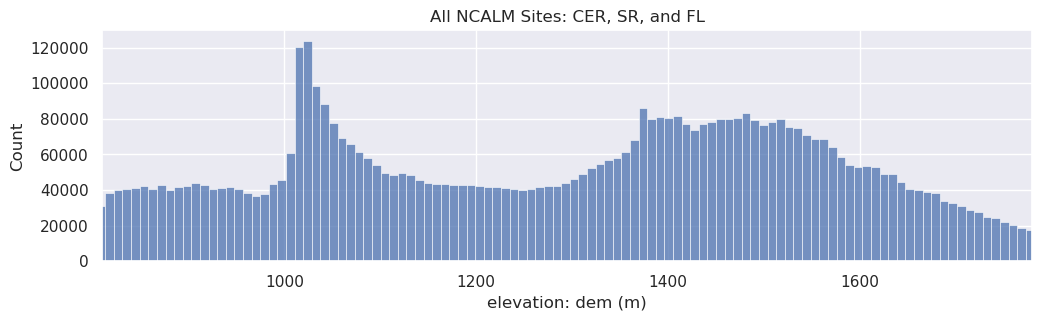

In [60]:
plt.rcParams['figure.figsize'] = [12,3] #overriding size
sns.histplot(data=df['dem'], bins=150)

# the range we are going with, less than 960, between 1030-1320, and greater than 1350

# Setting lines at the split values based on the PP


# plt.axvline(x=1100, color='grey',  alpha=.8) # previous value 
# plt.axvline(x=1340, color='grey',  alpha=.8) # previous value 

plt.title('All NCALM Sites: CER, SR, and FL')
plt.xlabel('elevation: dem (m)')
plt.xlim([810, 1780])

(810.0, 1780.0)

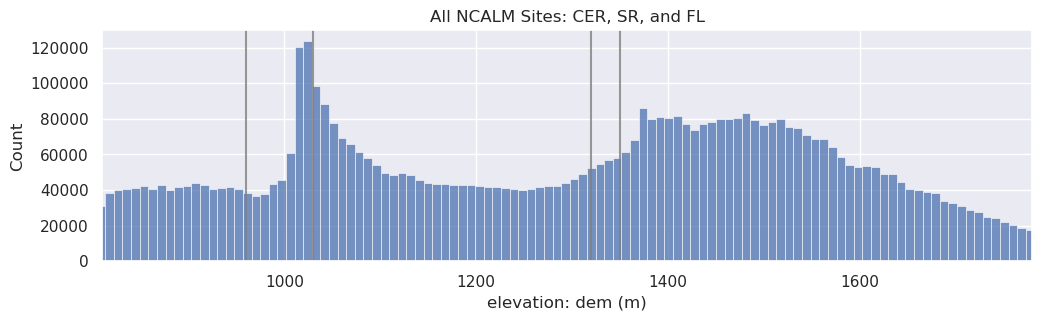

In [70]:
plt.rcParams['figure.figsize'] = [12,3] #overriding size
sns.histplot(data=df['dem'], bins=150)

# the range we are going with, less than 960, between 1030-1320, and greater than 1350

# Setting lines at the split values based on the PP
plt.axvline(x=960,  color='grey', alpha=.8) # trying this range
plt.axvline(x=1030, color='grey', alpha=.8) # trying this range

plt.axvline(x=1320,  color='grey', alpha=.8) # trying this range
plt.axvline(x=1350,  color='grey', alpha=.8) # trying this range

# color50 = 'lightblue'
# plt.axvspan(0,960, alpha=.2, color=color50)        # low zone
# plt.axvspan(1030, 1320, alpha=.2, color=color50)   # mid zone
# plt.axvspan(1350,2500,  alpha=.2, color=color50)    # high zone 

plt.title('All NCALM Sites: CER, SR, and FL')
plt.xlabel('elevation: dem (m)')
plt.xlim([810, 1780])

In [38]:
# df elevation
df_elevation = pd.DataFrame({'CER': df_ce.dem,
                   'SR': df_sr.dem, 
                   'FL': df_fl.dem})

df_elevation

,CER,SR,FL
39764,NaN,NaN,1977.838989
41223,NaN,NaN,1978.573364
41953,NaN,NaN,1977.650024
42682,NaN,NaN,1979.398193
42683,NaN,NaN,1976.408691
...,...,...,...
5367960,NaN,NaN,1658.413940
5368690,NaN,NaN,1658.688599
5370149,NaN,NaN,1658.351440
5372338,NaN,NaN,1658.190308


(810.0, 1780.0)

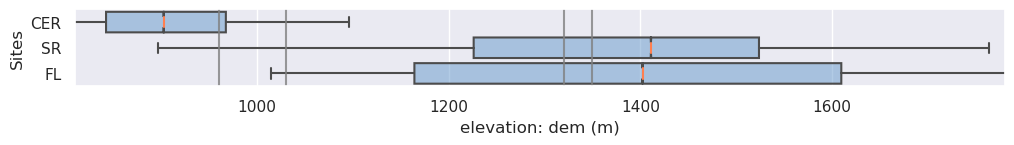

In [71]:
plt.rcParams['figure.figsize'] = [12,1] #overriding size


sns.boxplot(data=df_elevation, orient='h', 
            notch=True, showcaps=True, 
            flierprops={"marker": "x"},
            boxprops={"facecolor": (.4, .6, .8, .5)},
            medianprops={"color": "coral"})

# Setting lines at the split values based on the PP
plt.axvline(x=960,  color='grey', alpha=.8) # trying this range
plt.axvline(x=1030, color='grey', alpha=.8) # trying this range

plt.axvline(x=1320,  color='grey', alpha=.8) # trying this range
plt.axvline(x=1350,  color='grey', alpha=.8) # trying this range

# plt.title('All NCALM Sites: CER, SR, and FL')
plt.xlabel('elevation: dem (m)')
plt.ylabel('Sites')
plt.xlim([810, 1780])

(810.0, 1780.0)

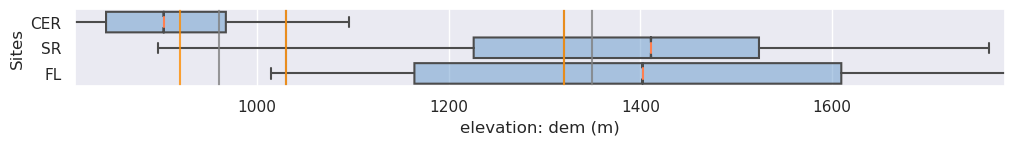

In [74]:
plt.rcParams['figure.figsize'] = [12,1] #overriding size


sns.boxplot(data=df_elevation, orient='h', 
            notch=True, showcaps=True, 
            flierprops={"marker": "x"},
            boxprops={"facecolor": (.4, .6, .8, .5)},
            medianprops={"color": "coral"})

# Setting lines at the split values based on the PP
plt.axvline(x=960,  color='grey', alpha=.8) # trying this range
plt.axvline(x=1030, color='grey', alpha=.8) # trying this range
plt.axvline(x=1320,  color='grey', alpha=.8) # trying this range
plt.axvline(x=1350,  color='grey', alpha=.8) # trying this range

color100='darkorange'
# adding lines for Susan's previous sites 
plt.axvline(x=920,  color=color100, alpha=.8)  # cer
plt.axvline(x=1030,  color=color100, alpha=.8) # fl
plt.axvline(x=1320,  color=color100, alpha=.8) # sr

# plt.title('All NCALM Sites: CER, SR, and FL')
plt.xlabel('elevation: dem (m)')
plt.ylabel('Sites')
plt.xlim([810, 1780])

## Prepare the dataset for Random Forest Model

In [40]:
df_int = df.copy(deep=True)
df_int['snowdepth'] = df_int['snowdepth'].astype(int)
df_int['dem'] = df_int['dem'].astype(int)
df_int['dah'] = df_int['dah'].astype(int)
df_int['dce'] = df_int['dce'].astype(int)
df_int['tpi'] = df_int['tpi'].astype(int)

df_int.head()

,snowdepth,dem,dah,tpi,dce,ce,sr,fl
88289,0,819,-6,-141,-8,ce,NaN,NaN
88914,0,819,-6,-173,-6,ce,NaN,NaN
90788,0,820,-5,-205,-9,ce,NaN,NaN
91413,0,820,-4,-201,-7,ce,NaN,NaN
92038,0,819,-11,-220,-5,ce,NaN,NaN


In [41]:
# create the x, variables, columns
X = df_int.drop(columns=['snowdepth'])
X.head()

,dem,dah,tpi,dce,ce,sr,fl
88289,819,-6,-141,-8,ce,NaN,NaN
88914,819,-6,-173,-6,ce,NaN,NaN
90788,820,-5,-205,-9,ce,NaN,NaN
91413,820,-4,-201,-7,ce,NaN,NaN
92038,819,-11,-220,-5,ce,NaN,NaN


In [42]:
# create the y, predictor, column
y = df_int.snowdepth
y.head()

88289    0
88914    0
90788    0
91413    0
92038    0
Name: snowdepth, dtype: int64

In [43]:
# x.describe()
X.isnull().values.any()
y.isnull().values.any()

False

# Bin Elevation Bands 
Using the bins found above by running the model with and looking at the PP with elevation

In [44]:
# break the data down by elevation bands 
# the range we are going with, less than 960, between 1030-1320, and greater than 1350

df_bin1 = df_int.where(df_int.dem < 960)                          # less than 1300
df_bin2 = df_int.where((df_int.dem >= 1030) & (df_int.dem < 1320)) # greater than or = 1300, less than 1370
df_bin3 = df_int.where(df_int.dem >= 1350)                         # greater than than 1370


# creating bins creates nan, so remove all for random forest 
df_bin1.dropna(how='any', inplace=True) # it has to be everything
df_bin2.dropna(how='any', inplace=True) # it has to be everything 
df_bin3.dropna(how='any', inplace=True) # it has to be everything 

# # 1. THIS SECTION
# # create the x, variables, columns
# X_bin1 = df_bin1.drop(columns=['snowdepth'])
# X_bin2 = df_bin2.drop(columns=['snowdepth'])
# X_bin3 = df_bin3.drop(columns=['snowdepth'])

# 2. OR THIS SECTION, if you want to remove dem from the random forest model 
# create the x, variables, columns
X_bin1 = df_bin1.drop(columns=['snowdepth', 'dem'])
X_bin2 = df_bin2.drop(columns=['snowdepth', 'dem'])
X_bin3 = df_bin3.drop(columns=['snowdepth', 'dem'])

# 3. Then, with either 1 or 2, run 3 
# create the y, predictor, column
y_bin1 = df_bin1.snowdepth
y_bin2 = df_bin2.snowdepth
y_bin3 = df_bin3.snowdepth

In [45]:
# check to make sure.. 
X_bin1.head()

,dah,tpi,dce,ce,sr,fl


# Load Saved Random Forest Models and Plot!

In [46]:
# Wrote the 1000 simulation model results to a file
filename1 = 'randomforest_bin1_1000.pkl'
# pickle.dump(clf1, open(filename1, 'wb')) # wb, writing 

filename2 = 'randomforest_bin2_1000.pkl'
# pickle.dump(clf2, open(filename2, 'wb')) # wb, writing

filename3 = 'randomforest_bin3_1000.pkl'
# pickle.dump(clf3, open(filename, 'wb')) # wb, writing

# Load the 1000 simulation model results 
clf1 = pickle.load(open(filename1, 'rb')) # rb, reading 
clf2 = pickle.load(open(filename2, 'rb')) # rb, reading 
clf3 = pickle.load(open(filename3, 'rb')) # rb, reading 

tree_model1 = clf1.best_estimator_
tree_model2 = clf2.best_estimator_
tree_model3 = clf3.best_estimator_

# Can do randomf forest things with them if we want 
# result1 = loaded_model1.score(X_test, y_test)
# print(result1)

FileNotFoundError: [Errno 2] No such file or directory: 'randomforest_bin1_1000.pkl'

In [ ]:
# bin 1
importances1 = tree_model1.feature_importances_
std1 = np.std([tree_model1.feature_importances_ for tree in tree_model1.estimators_], axis=0)

forest_importances1 = pd.Series(importances1, index=X_bin1.columns)

# bin 2
importances2 = tree_model2.feature_importances_
std2 = np.std([tree_model2.feature_importances_ for tree in tree_model2.estimators_], axis=0)

forest_importances2 = pd.Series(importances2, index=X_bin2.columns)

# bin 3
importances3 = tree_model3.feature_importances_
std3 = np.std([tree_model3.feature_importances_ for tree in tree_model3.estimators_], axis=0)

forest_importances3 = pd.Series(importances3, index=X_bin3.columns)

ValueError: Length of values (3) does not match length of index (6)

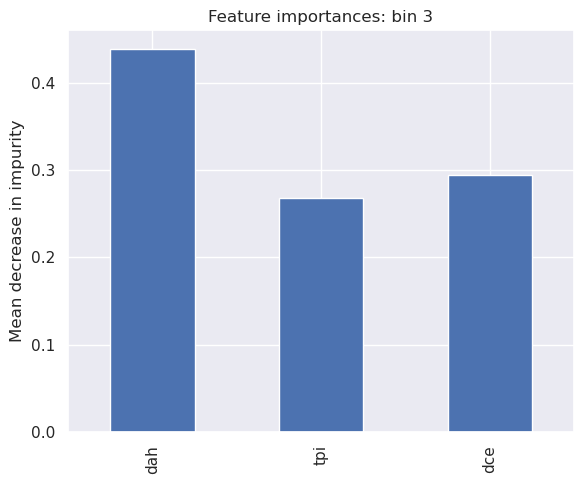

In [ ]:
# Plot Feature Importances 
fig, ax = plt.subplots(figsize=(6,5))
forest_importances3.plot.bar(yerr=std3, ax=ax)
ax.set_title("Feature importances: bin 3")dd
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
data_means = {
    'tpi': (forest_importances1.tpi, forest_importances2.tpi, forest_importances3.tpi),
    'dah': (forest_importances1.dah, forest_importances2.dah, forest_importances3.dah),
    'dce': (forest_importances1.dce, forest_importances2.dce, forest_importances3.dce),
}

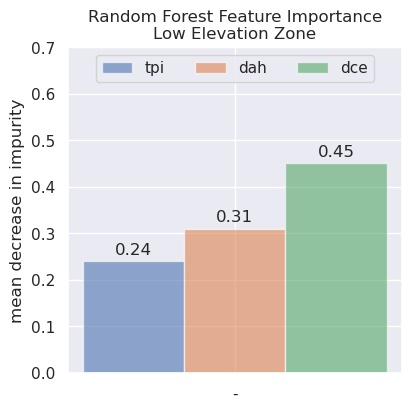

In [57]:
species = ("-")
data_means = {
    'tpi': (0.24), # 0.24
    'dah': (0.31), # 0.31
    'dce': (0.45)  # 0.45
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(4,4), layout='constrained')

for attribute, measurement in data_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, alpha=.6)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('mean decrease in impurity')
ax.set_title('Random Forest Feature Importance\nLow Elevation Zone')
ax.set_xticks(x + width, species)
ax.legend(loc='upper center', ncols=3)
ax.set_ylim(0, 0.7)

plt.show()

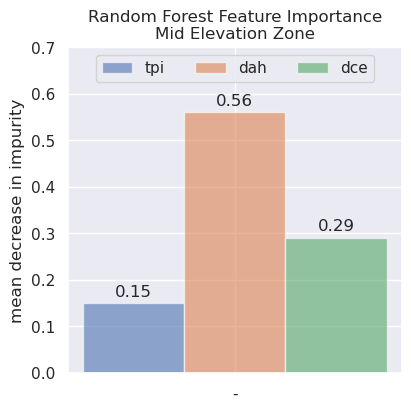

In [58]:
species = ("-")

data_means = {
    'tpi': (0.15), # 0.15
    'dah': (0.56), # 0.56
    'dce': (0.29)  # 0.29
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(4,4), layout='constrained')

for attribute, measurement in data_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, alpha=.6)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('mean decrease in impurity')
ax.set_title('Random Forest Feature Importance\nMid Elevation Zone')
ax.set_xticks(x + width, species)
ax.legend(loc='upper center', ncols=3)
ax.set_ylim(0, 0.7)

plt.show()

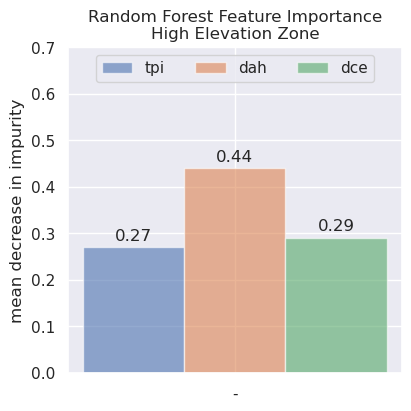

In [59]:
species = ("-")
# data_means = {
#     'tpi': (0.24), # 0.24
#     'dah': (0.31), # 0.31
#     'dce': (0.45)  # 0.45
# }

data_means = {
    'tpi': (0.27), # 0.27
    'dah': (0.44), # 0.44
    'dce': (0.29)  # 0.29
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(4,4), layout='constrained')

for attribute, measurement in data_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, alpha=.6)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('mean decrease in impurity')
ax.set_title('Random Forest Feature Importance\nHigh Elevation Zone')
ax.set_xticks(x + width, species)
ax.legend(loc='upper center', ncols=3)
ax.set_ylim(0, 0.7)

plt.show()

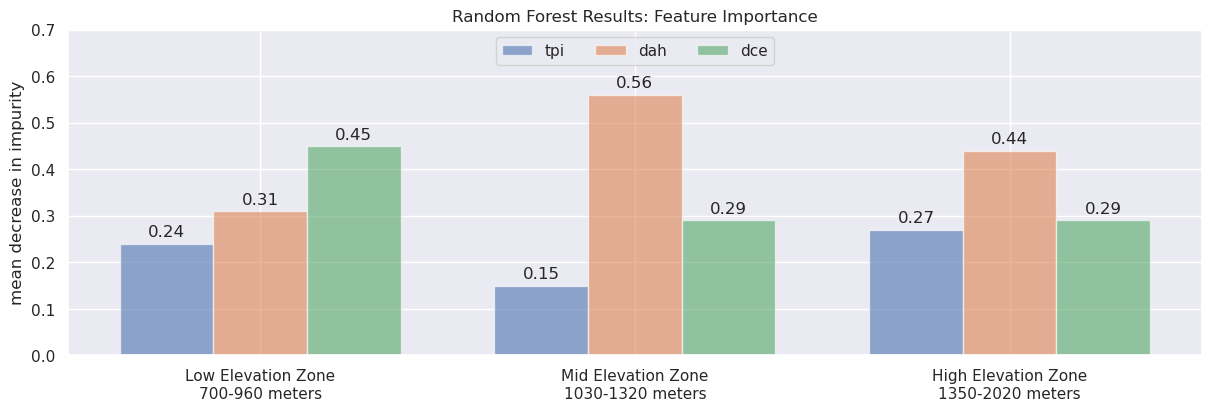

In [ ]:
species = ("Low Elevation Zone\n700-960 meters", "Mid Elevation Zone\n1030-1320 meters", "High Elevation Zone\n1350-2020 meters")

# data_means = {
#     'tpi': (forest_importances1.tpi, forest_importances2.tpi, forest_importances3.tpi),
#     'dah': (forest_importances1.dah, forest_importances2.dah, forest_importances3.dah),
#     'dce': (forest_importances1.dce, forest_importances2.dce, forest_importances3.dce),
# }

# bin 1 
data_means = {
    'tpi': (0.24, 0.15,0.27), 
    'dah': (0.31,0.56,0.44), 
    'dce': (0.45,0.29,0.29) 
}

# # bin 1 
# data_means = {
#     'tpi': (0.24), # 0.24
#     'dah': (0.31), # 0.31
#     'dce': (0.45)  # 0.45
# }

# # bin 2 
# data_means = {
#     'tpi': (0.15), # 0.15
#     'dah': (0.56), # 0.56
#     'dce': (0.29)  # 0.29
# }

# # bin 3 
# data_means = {
#     'tpi': (0.27), # 0.27
#     'dah': (0.44), # 0.44
#     'dce': (0.29)  # 0.29
# }


x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained')

for attribute, measurement in data_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, alpha=.6)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('mean decrease in impurity')
ax.set_title('Random Forest Results: Feature Importance')
ax.set_xticks(x + width, species)
ax.legend(loc='upper center', ncols=3)
ax.set_ylim(0, 0.7)

plt.show()

# Calculate the snow depth values inside the decision trees 

In [48]:
color_num1 = 'teal' # darkcyan
color_num2 = 'red'

In [49]:
all_bin1 = df.where(df.dem < 960)                       # less than 1300
all_bin2 = df.where((df.dem >= 1030) & (df.dem < 1320)) # greater than or = 1300, less than 1370
all_bin3 = df.where(df.dem >= 1350)                     # greater than than 1370

## Bin 1

In [ ]:
# # building the decision tree from top to bottom, row one through three (l:left, to r:right decisions)
# # row one 
# bin1_l 
# bin1_r 

# # row two
# bin1_ll  
# bin1_lr 
# bin1_rl
# bin1_rr

# # row three
# bin1_lll
# bin1_llr 

# bin1_lrl 
# bin1_lrr 

# bin1_rll 
# bin1_rlr

# bin1_rrl 
# bin1_rrr

In [ ]:
# building the decision tree from top to bottom, row one through three (l:left, to r:right decisions)
# row one 
bin1_l = all_bin1.snowdepth.where((all_bin1.dce <= 6.5)) 
bin1_r = all_bin1.snowdepth.where((all_bin1.dce >  6.5))

# row two
bin1_ll = all_bin1.snowdepth.where((all_bin1.dce <= 6.5) & (all_bin1.dah <= -0.285)) 
bin1_lr = all_bin1.snowdepth.where((all_bin1.dce <= 6.5) & (all_bin1.dah >  -0.285))
bin1_rl = all_bin1.snowdepth.where((all_bin1.dce >  6.5) & (all_bin1.tpi <= -2.185))
bin1_rr = all_bin1.snowdepth.where((all_bin1.dce >  6.5) & (all_bin1.tpi >  -2.185))

# row three
bin1_lll = all_bin1.snowdepth.where((all_bin1.dce <= 6.5) & (all_bin1.dah <= -.285) & (all_bin1.dce <=  2.5  ))  
bin1_llr = all_bin1.snowdepth.where((all_bin1.dce <= 6.5) & (all_bin1.dah <= -.285) & (all_bin1.dce >   2.5  ))

bin1_lrl = all_bin1.snowdepth.where((all_bin1.dce <= 6.5) & (all_bin1.dah >  -.285) & (all_bin1.tpi <= -5.025)) 
bin1_lrr = all_bin1.snowdepth.where((all_bin1.dce <= 6.5) & (all_bin1.dah >  -.285) & (all_bin1.tpi >  -5.025))

bin1_rll = all_bin1.snowdepth.where((all_bin1.dce >  6.5) & (all_bin1.tpi <= -2.185) & (all_bin1.dce <=  13.5)) 
bin1_rlr = all_bin1.snowdepth.where((all_bin1.dce >  6.5) & (all_bin1.tpi <= -2.185) & (all_bin1.dce >   13.5))

bin1_rrl = all_bin1.snowdepth.where((all_bin1.dce >  6.5) & (all_bin1.tpi >  -2.185) & (all_bin1.tpi <= 2.345)) 
bin1_rrr = all_bin1.snowdepth.where((all_bin1.dce >  6.5) & (all_bin1.tpi >  -2.185) & (all_bin1.tpi >  2.345))

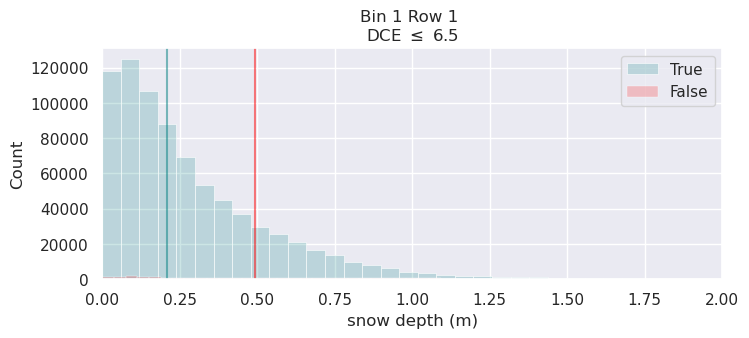

In [ ]:
# Figure for all random forest results
# Bin 1, Row 1
plt.rcParams['figure.figsize'] = [8,3] #overriding size
sns.histplot(data=bin1_l, bins=100, color=color_num1, label='True', alpha=.2)
sns.histplot(data=bin1_r, bins=100, color=color_num2, label='False', alpha=.2)

plt.axvline(x=bin1_l.median(),  color=color_num1, alpha=.5) 
plt.axvline(x=bin1_r.median(),  color=color_num2, alpha=.5) 

plt.title('Bin 1 Row 1 \nDCE $\leq$ 6.5')
# plt.ylim([0,2000])
plt.xlim([0,2])

plt.xlabel('snow depth (m)')
plt.legend()

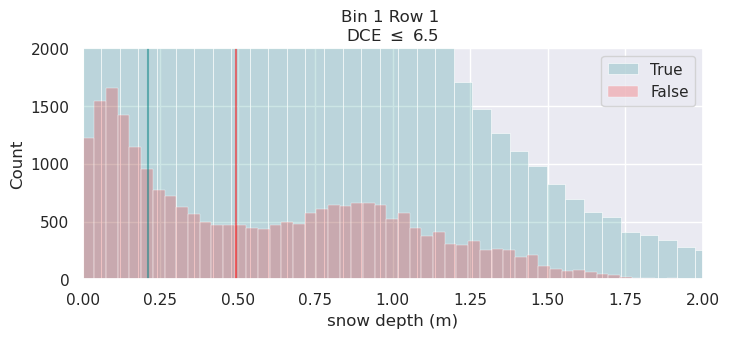

In [ ]:
# Figure for all random forest results
# Bin 1, Row 1
plt.rcParams['figure.figsize'] = [8,3] #overriding size
sns.histplot(data=bin1_l, bins=100, color=color_num1, label='True', alpha=.2)
sns.histplot(data=bin1_r, bins=100, color=color_num2, label='False', alpha=.2)

plt.axvline(x=bin1_l.median(),  color=color_num1, alpha=.5) 
plt.axvline(x=bin1_r.median(),  color=color_num2, alpha=.5) 

plt.title('Bin 1 Row 1 \nDCE $\leq$ 6.5')
plt.ylim([0,2000])
plt.xlim([0,2])

plt.xlabel('snow depth (m)')
plt.legend()

(0.0, 2.0)

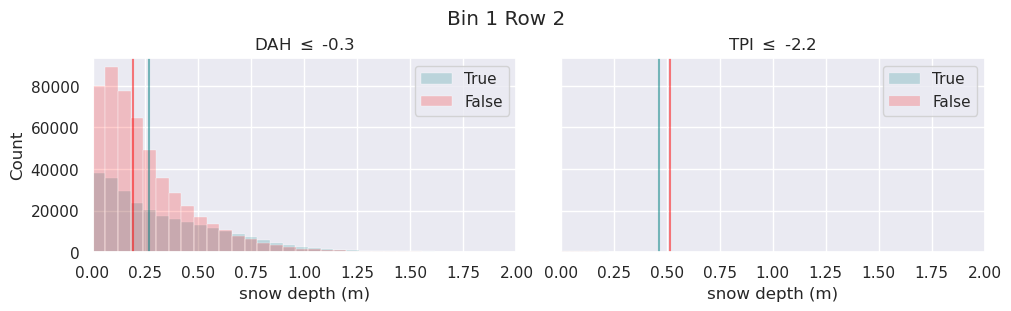

In [ ]:
# Figure for all random forest results
# Bin 1, Row 2
fig, axes = plt.subplots(1,2, figsize=(10,3), constrained_layout = True, sharex=True, sharey=True)
fig.suptitle('Bin 1 Row 2')

# DAH
sns.histplot(ax=axes[0], data=bin1_ll, bins=100, color=color_num1, label='True', alpha=.2)
axes[0].axvline(x=bin1_ll.median(),  color=color_num1, alpha=.5) 
sns.histplot(ax=axes[0], data=bin1_lr, bins=100, color=color_num2, label='False', alpha=.2)
axes[0].axvline(x=bin1_lr.median(),  color=color_num2, alpha=.5) 

# TPI
sns.histplot(ax=axes[1], data=bin1_rl, bins=100, color=color_num1, label='True', alpha=.2)
axes[1].axvline(x=bin1_rl.median(),  color=color_num1, alpha=.5) 
sns.histplot(ax=axes[1], data=bin1_rr, bins=100, color=color_num2, label='False', alpha=.2)
axes[1].axvline(x=bin1_rr.median(),  color=color_num2, alpha=.5) 

# Set labels  
axes[0].set_title("DAH $\leq$ -0.3")
axes[1].set_title("TPI $\leq$ -2.2")

axes[0].set_xlabel('snow depth (m)')
axes[1].set_xlabel('snow depth (m)')

axes[0].legend()
axes[1].legend()

# Set limits 
axes[0].set_xlim([0, 2])
axes[1].set_xlim([0, 2])

# axes[0].set_ylim([0, 10000])
# axes[1].set_ylim([0, 10000])

(0.0, 2.0)

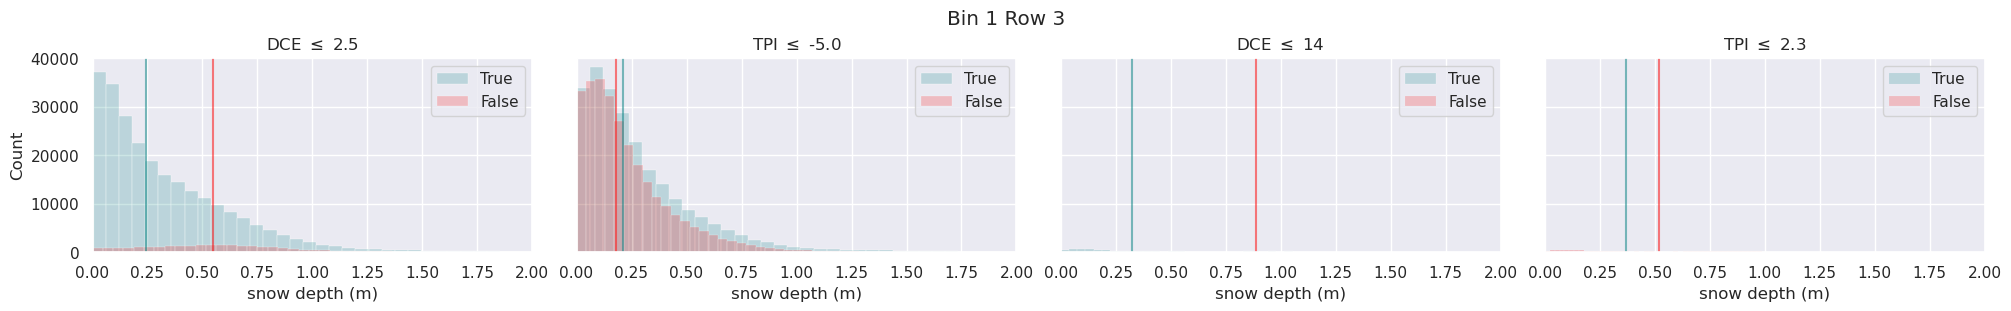

In [ ]:
# Figure for all random forest results
# Bin 1, Row 3
fig, axes = plt.subplots(1,4, figsize=(20,3), constrained_layout = True, sharex=True, sharey=True)
fig.suptitle('Bin 1 Row 3')

# DCE
sns.histplot(ax=axes[0], data=bin1_lll, bins=100, color=color_num1, label='True', alpha=.2)
sns.histplot(ax=axes[0], data=bin1_llr, bins=100, color=color_num2, label='False', alpha=.2)

axes[0].axvline(x=bin1_lll.median(),  color=color_num1, alpha=.5) 
axes[0].axvline(x=bin1_llr.median(),  color=color_num2, alpha=.5) 

# TPI
sns.histplot(ax=axes[1], data=bin1_lrl, bins=100, color=color_num1, label='True', alpha=.2)
sns.histplot(ax=axes[1], data=bin1_lrr, bins=100, color=color_num2, label='False', alpha=.2)

axes[1].axvline(x=bin1_lrl.median(),  color=color_num1, alpha=.5) 
axes[1].axvline(x=bin1_lrr.median(),  color=color_num2, alpha=.5) 

# TPI
sns.histplot(ax=axes[2], data=bin1_rll, bins=100, color=color_num1, label='True', alpha=.2)
sns.histplot(ax=axes[2], data=bin1_rlr, bins=100, color=color_num2, label='False', alpha=.2)

axes[2].axvline(x=bin1_rll.median(),  color=color_num1, alpha=.5) 
axes[2].axvline(x=bin1_rlr.median(),  color=color_num2, alpha=.5) 

# DAH
sns.histplot(ax=axes[3], data=bin1_rrl, bins=100, color=color_num1, label='True', alpha=.2)
sns.histplot(ax=axes[3], data=bin1_rrr, bins=100, color=color_num2, label='False', alpha=.2)

axes[3].axvline(x=bin1_rrl.median(),  color=color_num1, alpha=.5) 
axes[3].axvline(x=bin1_rrr.median(),  color=color_num2, alpha=.5) 

# Set labels 
axes[0].set_title("DCE $\leq$ 2.5")
axes[1].set_title("TPI $\leq$ -5.0")
axes[2].set_title("DCE $\leq$ 14")
axes[3].set_title("TPI $\leq$ 2.3")

axes[0].set_xlabel('snow depth (m)')
axes[1].set_xlabel('snow depth (m)')
axes[2].set_xlabel('snow depth (m)')
axes[3].set_xlabel('snow depth (m)')

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()

# Set limits 
# Set limits 
axes[0].set_xlim([0, 2])
axes[1].set_xlim([0, 2])
axes[2].set_xlim([0, 2])
axes[3].set_xlim([0, 2])

# axes[0].set_ylim([0, 10000])
# axes[1].set_ylim([0, 10000])
# axes[2].set_ylim([0, 10000])
# axes[3].set_ylim([0, 10000])


## Bin 2

In [ ]:
# building the decision tree from top to bottom, row one through three (l:left, to r:right decisions)
# row one 
bin2_l = all_bin2.snowdepth.where((all_bin2.dce <= -0.5))
bin2_r = all_bin2.snowdepth.where((all_bin2.dce >  -0.5))

# row two 
bin2_ll = all_bin2.snowdepth.where((all_bin2.dce <= -0.5) & (all_bin2.dah <= -.095))
bin2_lr = all_bin2.snowdepth.where((all_bin2.dce <= -0.5) & (all_bin2.dah >  -.095))
bin2_rl = all_bin2.snowdepth.where((all_bin2.dce >  -0.5) & (all_bin2.dah <=  .225))
bin2_rr = all_bin2.snowdepth.where((all_bin2.dce >  -0.5) & (all_bin2.dah >   .225))

# row three
bin2_lll = all_bin2.snowdepth.where((all_bin2.dce <= -0.5) & (all_bin2.dah <= -.095) & (all_bin2.tpi <= 1.525)) # only difference between a and b is the tpi 
bin2_llr = all_bin2.snowdepth.where((all_bin2.dce <= -0.5) & (all_bin2.dah <= -.095) & (all_bin2.tpi >  1.525))

bin2_lrl = all_bin2.snowdepth.where((all_bin2.dce <= -0.5) & (all_bin2.dah > -.095) & (all_bin2.dce <=  -1.5)) # only difference between c and d is dce
bin2_lrr = all_bin2.snowdepth.where((all_bin2.dce <= -0.5) & (all_bin2.dah > -.095) & (all_bin2.dce >   -1.5))

bin2_rll = all_bin2.snowdepth.where((all_bin2.dce > -0.5)  & (all_bin2.dah <= .225) & (all_bin2.dah <= -.165)) # only difference between e and f is dah
bin2_rlr = all_bin2.snowdepth.where((all_bin2.dce > -0.5)  & (all_bin2.dah <= .225) & (all_bin2.dah >  -.165))

bin2_rrl = all_bin2.snowdepth.where((all_bin2.dce > -0.5)  & (all_bin2.dah >  .225) & (all_bin2.dah <=  .435)) # only difference between g and h is dah
bin2_rrr = all_bin2.snowdepth.where((all_bin2.dce > -0.5)  & (all_bin2.dah >  .225) & (all_bin2.dah >   .435))

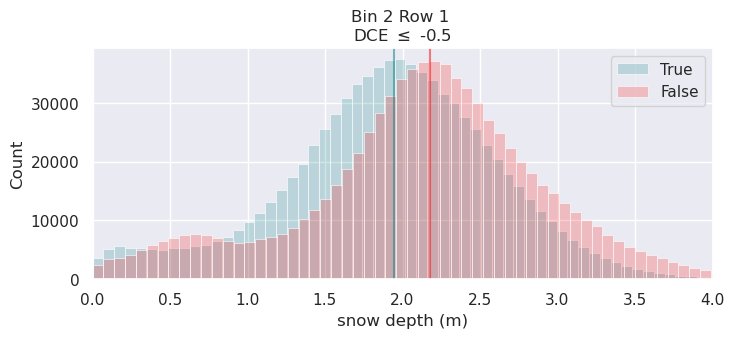

In [ ]:
# Figure for all random forest results
# Bin 2, Row 1
plt.rcParams['figure.figsize'] = [8,3] #overriding size
sns.histplot(data=bin2_l, bins=100, color=color_num1, label='True', alpha=.2)
sns.histplot(data=bin2_r, bins=100, color=color_num2, label='False', alpha=.2)

plt.axvline(x=bin2_l.median(),  color=color_num1, alpha=.5) 
plt.axvline(x=bin2_r.median(),  color=color_num2, alpha=.5) 

plt.title('Bin 2 Row 1 \nDCE $\leq$ -0.5')
# plt.ylim([0,2000])
plt.xlim([0,4])

plt.xlabel('snow depth (m)')
plt.legend()

(0.0, 4.0)

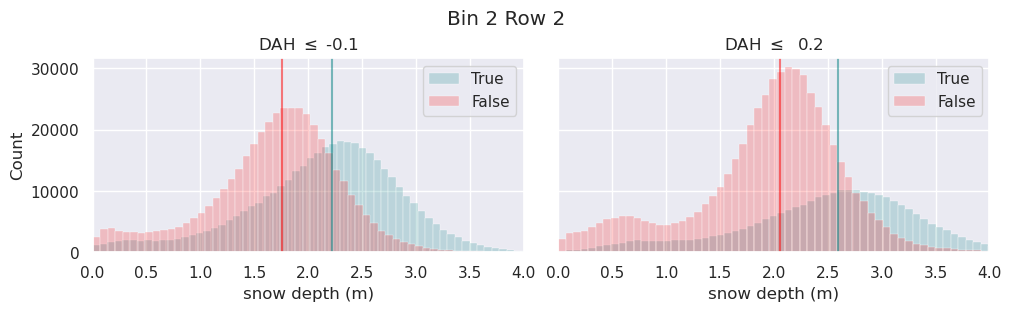

In [ ]:
# Figure for all random forest results
# Bin 2, Row 2
fig, axes = plt.subplots(1,2, figsize=(10,3), constrained_layout = True, sharex=True, sharey=True)
fig.suptitle('Bin 2 Row 2')

# DAH
sns.histplot(ax=axes[0], data=bin2_ll, bins=100, color=color_num1, label='True', alpha=.2)
axes[0].axvline(x=bin2_ll.median(),  color=color_num1, alpha=.5) 
sns.histplot(ax=axes[0], data=bin2_lr, bins=100, color=color_num2, label='False', alpha=.2)
axes[0].axvline(x=bin2_lr.median(),  color=color_num2, alpha=.5) 

# TPI
sns.histplot(ax=axes[1], data=bin2_rl, bins=100, color=color_num1, label='True', alpha=.2)
axes[1].axvline(x=bin2_rl.median(),  color=color_num1, alpha=.5) 
sns.histplot(ax=axes[1], data=bin2_rr, bins=100, color=color_num2, label='False', alpha=.2)
axes[1].axvline(x=bin2_rr.median(),  color=color_num2, alpha=.5) 

# Set labels  
axes[0].set_title("DAH $\leq$ -0.1")
axes[1].set_title("DAH $\leq$  0.2")

axes[0].set_xlabel('snow depth (m)')
axes[1].set_xlabel('snow depth (m)')

axes[0].legend()
axes[1].legend()

# Set limits 
axes[0].set_xlim([0, 4])
axes[1].set_xlim([0, 4])

# axes[0].set_ylim([0, 10000])
# axes[1].set_ylim([0, 10000])

(0.0, 4.0)

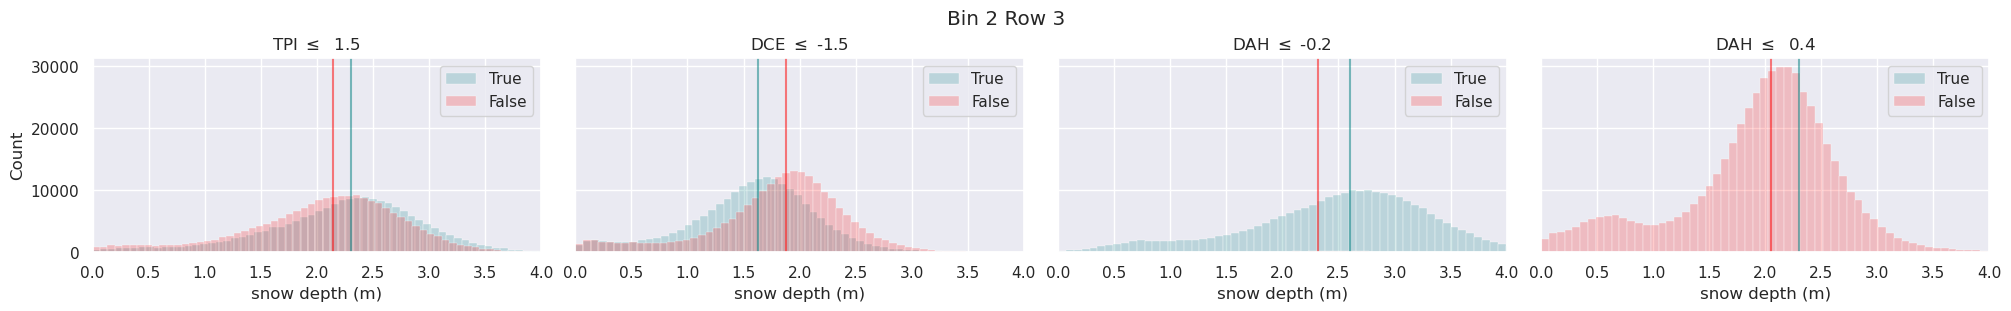

In [ ]:
# Figure for all random forest results
fig, axes = plt.subplots(1,4, figsize=(20,3), constrained_layout = True, sharex=True, sharey=True)
fig.suptitle('Bin 2 Row 3')

# # row three
# bin1_lll
# bin1_llr 

# bin1_lrl 
# bin1_lrr 

# bin1_rll 
# bin1_rlr

# bin1_rrl 
# bin1_rrr

# DCE
sns.histplot(ax=axes[0], data=bin2_lll, bins=100, color=color_num1, label='True', alpha=.2)
sns.histplot(ax=axes[0], data=bin2_llr, bins=100, color=color_num2, label='False', alpha=.2)

axes[0].axvline(x=bin2_lll.median(),  color=color_num1, alpha=.5) 
axes[0].axvline(x=bin2_llr.median(),  color=color_num2, alpha=.5) 

# TPI
sns.histplot(ax=axes[1], data=bin2_lrl, bins=100, color=color_num1, label='True', alpha=.2)
sns.histplot(ax=axes[1], data=bin2_lrr, bins=100, color=color_num2, label='False', alpha=.2)

axes[1].axvline(x=bin2_lrl.median(),  color=color_num1, alpha=.5) 
axes[1].axvline(x=bin2_lrr.median(),  color=color_num2, alpha=.5) 

# TPI
sns.histplot(ax=axes[2], data=bin2_rll, bins=100, color=color_num1, label='True', alpha=.2)
sns.histplot(ax=axes[2], data=bin2_rlr, bins=100, color=color_num2, label='False', alpha=.2)

axes[2].axvline(x=bin2_rll.median(),  color=color_num1, alpha=.5) 
axes[2].axvline(x=bin2_rlr.median(),  color=color_num2, alpha=.5) 

# DAH
sns.histplot(ax=axes[3], data=bin2_rrl, bins=100, color=color_num1, label='True', alpha=.2)
sns.histplot(ax=axes[3], data=bin2_rrr, bins=100, color=color_num2, label='False', alpha=.2)

axes[3].axvline(x=bin2_rrl.median(),  color=color_num1, alpha=.5) 
axes[3].axvline(x=bin2_rrr.median(),  color=color_num2, alpha=.5) 


# Set labels 
axes[0].set_title("TPI $\leq$  1.5")
axes[1].set_title("DCE $\leq$ -1.5")
axes[2].set_title("DAH $\leq$ -0.2")
axes[3].set_title("DAH $\leq$  0.4")

axes[0].set_xlabel('snow depth (m)')
axes[1].set_xlabel('snow depth (m)')
axes[2].set_xlabel('snow depth (m)')
axes[3].set_xlabel('snow depth (m)')

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()

# Set limits 
axes[0].set_xlim([0, 4])
axes[1].set_xlim([0, 4])
axes[2].set_xlim([0, 4])
axes[3].set_xlim([0, 4])

# axes[0].set_ylim([0, 10000])
# axes[1].set_ylim([0, 10000])
# axes[2].set_ylim([0, 10000])
# axes[3].set_ylim([0, 10000])

## Bin 3

In [ ]:
# building the decision tree from top to bottom, row one through three (l:left, to r:right decisions)
# row one 
bin3_l = all_bin3.snowdepth.where((all_bin3.dah <= .265)) 
bin3_r = all_bin3.snowdepth.where((all_bin3.dah >  .265)) 

# row two 
bin3_ll = all_bin3.snowdepth.where((all_bin3.dah <= .265) & (all_bin3.dah <= -.325))
bin3_lr = all_bin3.snowdepth.where((all_bin3.dah <= .265) & (all_bin3.dah >  -.325)) 
bin3_rl = all_bin3.snowdepth.where((all_bin3.dah >  .265) & (all_bin3.tpi <= 0.855)) 
bin3_rr = all_bin3.snowdepth.where((all_bin3.dah >  .265) & (all_bin3.tpi >  0.855))

# row three 
bin3_lll = all_bin3.snowdepth.where((all_bin3.dah <= .265) & (all_bin3.dah <= -.325) & (all_bin3.dce <= -0.5)) # only difference between a and b is the dce 
bin3_llr = all_bin3.snowdepth.where((all_bin3.dah <= .265) & (all_bin3.dah <= -.325) & (all_bin3.dce >  -0.5))

bin3_lrl = all_bin3.snowdepth.where((all_bin3.dah <= .265) & (all_bin3.dah > -.325) & (all_bin3.tpi <= 0.825)) # only difference between c and d is tpi
bin3_lrr = all_bin3.snowdepth.where((all_bin3.dah <= .265) & (all_bin3.dah > -.325) & (all_bin3.tpi >  0.825))

bin3_rll = all_bin3.snowdepth.where((all_bin3.dah > .265) & (all_bin3.tpi <= 0.855) & (all_bin3.tpi <= 0.285)) # only difference between e and f is tpi
bin3_rlr = all_bin3.snowdepth.where((all_bin3.dah > .265) & (all_bin3.tpi <= 0.855) & (all_bin3.tpi >  0.285))

bin3_rrl = all_bin3.snowdepth.where((all_bin3.dah > .265) & (all_bin3.tpi >  0.855) & (all_bin3.dah <= 0.525)) # only difference between g and h is dah
bin3_rrr = all_bin3.snowdepth.where((all_bin3.dah > .265) & (all_bin3.tpi >  0.855) & (all_bin3.dah >  0.525)) 

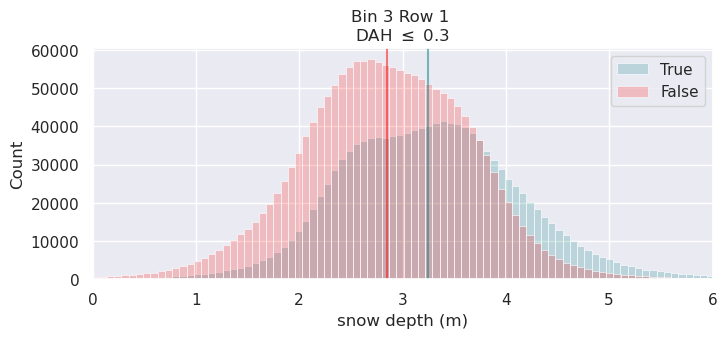

In [ ]:
# Figure for all random forest results
# Bin 3, Row 1
plt.rcParams['figure.figsize'] = [8,3] #overriding size
sns.histplot(data=bin3_l, bins=100, color=color_num1, label='True', alpha=.2)
sns.histplot(data=bin3_r, bins=100, color=color_num2, label='False', alpha=.2)

plt.axvline(x=bin3_l.median(),  color=color_num1, alpha=.5) 
plt.axvline(x=bin3_r.median(),  color=color_num2, alpha=.5) 

plt.title('Bin 3 Row 1 \nDAH $\leq$ 0.3')
# plt.ylim([0,2000])
plt.xlim([0,6])

plt.xlabel('snow depth (m)')
plt.legend()

(0.0, 6.0)

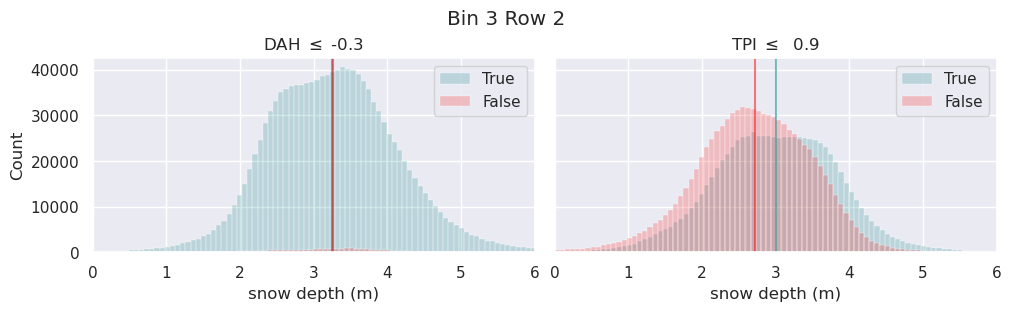

In [ ]:
# Figure for all random forest results
# Bin 3, Row 2
fig, axes = plt.subplots(1,2, figsize=(10,3), constrained_layout = True, sharex=True, sharey=True)
fig.suptitle('Bin 3 Row 2')

# DAH
sns.histplot(ax=axes[0], data=bin3_ll, bins=100, color=color_num1, label='True', alpha=.2)
axes[0].axvline(x=bin3_ll.median(),  color=color_num1, alpha=.5) 
sns.histplot(ax=axes[0], data=bin3_lr, bins=100, color=color_num2, label='False', alpha=.2)
axes[0].axvline(x=bin3_lr.median(),  color=color_num2, alpha=.5) 

# TPI
sns.histplot(ax=axes[1], data=bin3_rl, bins=100, color=color_num1, label='True', alpha=.2)
axes[1].axvline(x=bin3_rl.median(),  color=color_num1, alpha=.5) 
sns.histplot(ax=axes[1], data=bin3_rr, bins=100, color=color_num2, label='False', alpha=.2)
axes[1].axvline(x=bin3_rr.median(),  color=color_num2, alpha=.5) 

# Set labels  
axes[0].set_title("DAH $\leq$ -0.3") 
axes[1].set_title("TPI $\leq$  0.9") 

axes[0].set_xlabel('snow depth (m)')
axes[1].set_xlabel('snow depth (m)')

axes[0].legend()
axes[1].legend()

# Set limits 
axes[0].set_xlim([0, 6])
axes[1].set_xlim([0, 6])

# axes[0].set_ylim([0, 10000])
# axes[1].set_ylim([0, 10000])

(0.0, 6.0)

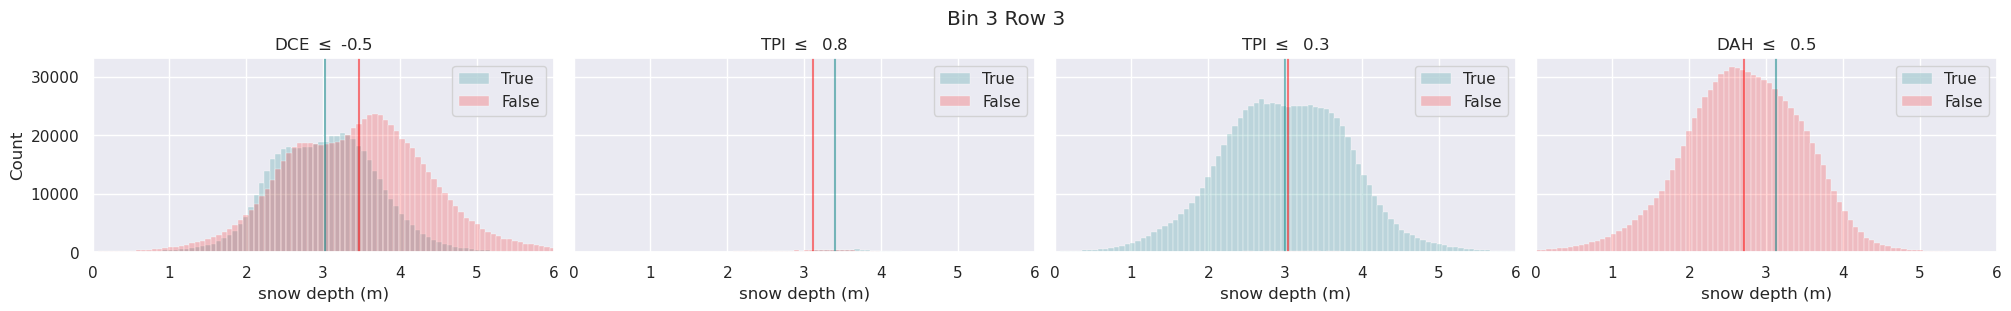

In [ ]:
# Figure for all random forest results
fig, axes = plt.subplots(1,4, figsize=(20,3), constrained_layout = True, sharex=True, sharey=True)
fig.suptitle('Bin 3 Row 3')

# DCE
sns.histplot(ax=axes[0], data=bin3_lll, bins=100, color=color_num1, label='True', alpha=.2)
sns.histplot(ax=axes[0], data=bin3_llr, bins=100, color=color_num2, label='False', alpha=.2)

axes[0].axvline(x=bin3_lll.median(),  color=color_num1, alpha=.5) 
axes[0].axvline(x=bin3_llr.median(),  color=color_num2, alpha=.5) 

# TPI
sns.histplot(ax=axes[1], data=bin3_lrl, bins=100, color=color_num1, label='True', alpha=.2)
sns.histplot(ax=axes[1], data=bin3_lrr, bins=100, color=color_num2, label='False', alpha=.2)

axes[1].axvline(x=bin3_lrl.median(),  color=color_num1, alpha=.5) 
axes[1].axvline(x=bin3_lrr.median(),  color=color_num2, alpha=.5) 

# TPI
sns.histplot(ax=axes[2], data=bin3_rll, bins=100, color=color_num1, label='True', alpha=.2)
sns.histplot(ax=axes[2], data=bin3_rlr, bins=100, color=color_num2, label='False', alpha=.2)

axes[2].axvline(x=bin3_rll.median(),  color=color_num1, alpha=.5) 
axes[2].axvline(x=bin3_rlr.median(),  color=color_num2, alpha=.5) 

# DAH
sns.histplot(ax=axes[3], data=bin3_rrl, bins=100, color=color_num1, label='True', alpha=.2)
sns.histplot(ax=axes[3], data=bin3_rrr, bins=100, color=color_num2, label='False', alpha=.2)

axes[3].axvline(x=bin3_rrl.median(),  color=color_num1, alpha=.5) 
axes[3].axvline(x=bin3_rrr.median(),  color=color_num2, alpha=.5) 


# Set labels 
axes[0].set_title("DCE $\leq$ -0.5")
axes[1].set_title("TPI $\leq$  0.8")
axes[2].set_title("TPI $\leq$  0.3")
axes[3].set_title("DAH $\leq$  0.5")

axes[0].set_xlabel('snow depth (m)')
axes[1].set_xlabel('snow depth (m)')
axes[2].set_xlabel('snow depth (m)')
axes[3].set_xlabel('snow depth (m)')

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()

# Set limits 
axes[0].set_xlim([0, 6])
axes[1].set_xlim([0, 6])
axes[2].set_xlim([0, 6])
axes[3].set_xlim([0, 6])

# axes[0].set_ylim([0, 10000])
# axes[1].set_ylim([0, 10000])
# axes[2].set_ylim([0, 10000])
# axes[3].set_ylim([0, 10000])


# Other Plots with the data

(-40.0, 40.0)

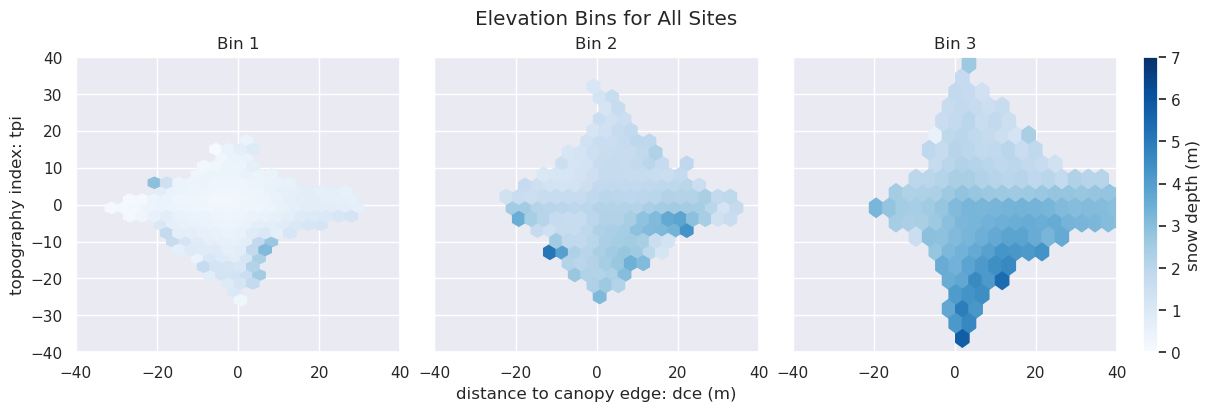

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(12,4), constrained_layout = True, sharex=True, sharey=True)
fig.suptitle('Elevation Bins for All Sites')

p1 = axes[0].hexbin(all_bin1.dce, (all_bin1.tpi)/100, all_bin1.snowdepth, cmap='Blues', vmin=0, vmax=7, mincnt=2, gridsize=20)
p2 = axes[1].hexbin(all_bin2.dce, (all_bin2.tpi)/100, all_bin2.snowdepth, cmap='Blues', vmin=0, vmax=7, mincnt=2, gridsize=20)
p3 = axes[2].hexbin(all_bin3.dce, (all_bin3.tpi)/100, all_bin3.snowdepth, cmap='Blues', vmin=0, vmax=7, mincnt=2, gridsize=20)

axes[1].set_xlabel('distance to canopy edge: dce (m)')
axes[0].set_ylabel('topography index: tpi')

axes[0].set_title("Bin 1")
axes[1].set_title("Bin 2")
axes[2].set_title("Bin 3")

cb = fig.colorbar(p3, ax=axes[2])
cb.set_label('snow depth (m)')

plt.xlim([-40,40])
plt.ylim([-40,40])

(-20.0, 40.0)

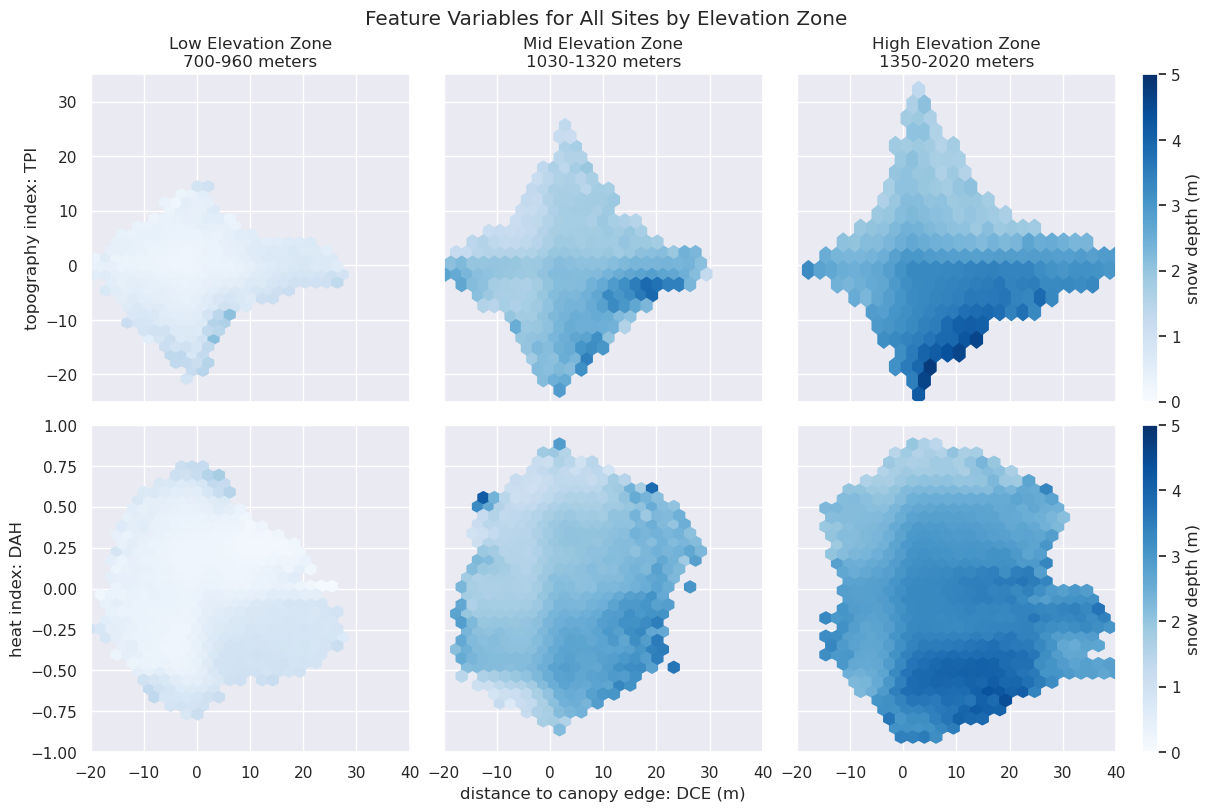

In [54]:
fig, axes = plt.subplots(2,3, figsize=(12,8), constrained_layout = True, sharex='col', sharey='row')
fig.suptitle('Feature Variables for All Sites by Elevation Zone')

mincount = 10
gridsize = 30

# plots 
p1 = axes[0,0].hexbin(all_bin1.dce, (all_bin1.tpi)/100, all_bin1.snowdepth, cmap='Blues', vmin=0, vmax=5, mincnt=mincount, gridsize=gridsize)
p2 = axes[0,1].hexbin(all_bin2.dce, (all_bin2.tpi)/100, all_bin2.snowdepth, cmap='Blues', vmin=0, vmax=5, mincnt=mincount, gridsize=gridsize)
p3 = axes[0,2].hexbin(all_bin3.dce, (all_bin3.tpi)/100, all_bin3.snowdepth, cmap='Blues', vmin=0, vmax=5, mincnt=mincount, gridsize=gridsize)

p4 = axes[1,0].hexbin(all_bin1.dce, (all_bin1.dah)/100, all_bin1.snowdepth, cmap='Blues', vmin=0, vmax=5, mincnt=mincount, gridsize=gridsize)
p5 = axes[1,1].hexbin(all_bin2.dce, (all_bin2.dah)/100, all_bin2.snowdepth, cmap='Blues', vmin=0, vmax=5, mincnt=mincount, gridsize=gridsize)
p6 = axes[1,2].hexbin(all_bin3.dce, (all_bin3.dah)/100, all_bin3.snowdepth, cmap='Blues', vmin=0, vmax=5, mincnt=mincount, gridsize=gridsize)

# labels 
axes[0,0].set_title('Low Elevation Zone\n700-960 meters')
axes[0,1].set_title('Mid Elevation Zone\n1030-1320 meters')
axes[0,2].set_title('High Elevation Zone\n1350-2020 meters')

axes[0,0].set_ylabel('topography index: TPI')
axes[1,0].set_ylabel('heat index: DAH')
axes[1,1].set_xlabel('distance to canopy edge: DCE (m)')

# colorbar
cb1 = fig.colorbar(p3, ax=axes[0,2])
cb2 = fig.colorbar(p6, ax=axes[1,2])

cb1.set_label('snow depth (m)')
cb2.set_label('snow depth (m)')

# shared axes have same limits
axes[0,0].set_ylim([-25,35]) # row 1 tpi y lim
axes[1,0].set_ylim([-1,1])   # row 2 dah y lim

axes[1,0].set_xlim([-20,40]) # col 1 dce x lim
axes[1,1].set_xlim([-20,40]) # col 2 dce x lim
axes[1,2].set_xlim([-20,40]) # col 3 dce x lim

for the other box plots, we would need to make reclass groups. We could instead, use the split values from random forest

In [51]:
# plt.figure(figsize=(12,6))

# sns.boxplot(x=all_bin1.dce, y=snowdepth_flat, hue=dah_reclass_flat, notch=True, showcaps=False, medianprops={"color":"coral"}) # palette={1: 'orange', -1: 'blue'})
# plt.xlabel('dce (m)')
# plt.ylabel('snow depth (m)')
# plt.title('Bin 1')
# plt.xticks([0,1,2,3,4], ['Large Clusters','Small Clusters','Edges','Small Gaps', 'Large Gaps'])
# plt.legend('')
# # 100: large clusters, 200: small clusters, 300: edges, 400: small gaps, 500: large gaps 

# plt.show()